# Outlier detection using Bayesian Methods and MCMC

In [29]:
%matplotlib inline
import numpy as np
import scipy
import pymc
import random
import matplotlib.pylab as plt

In [30]:
a = 2
x = np.arange(10,50,.5)
# Add some noise
x += np.random.normal(size=x.size)
y = a * x + 10

#y = a * np.sin(x) + 5
y_with_outlier = np.copy(y)

# Add some outliers
for ii in np.arange(len(x)/5, len(x), len(x)/5.):
    y_with_outlier[ii]= 60*(random.random()-.5) + y[ii]
    
y_with_outlier = np.asarray(y_with_outlier)
# assuming I do not know, just fill it with ones
spread = np.asarray([1 for _ in range(y_with_outlier.size)])

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


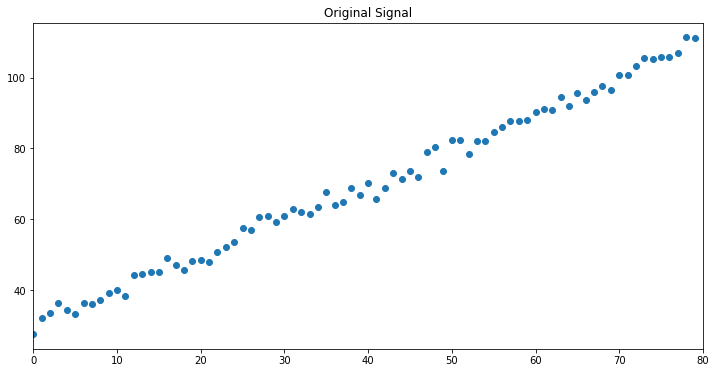

In [31]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y)), y);
plt.title('Original Signal');
plt.xlim([0, len(y)]);

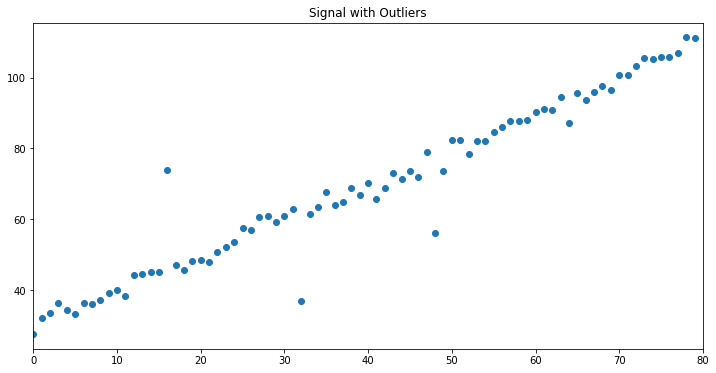

In [32]:
plt.figure(figsize=(12, 6));
plt.scatter(range(y_with_outlier.size), y_with_outlier);
plt.title('Signal with Outliers');
plt.xlim([0, len(y_with_outlier)]);

In [33]:
outlier_points = pymc.Uniform('outlier_points', 0, 1.0, value=0.1)
mean_outliers = pymc.Uniform('mean_outliers', -100, 100, value=0)
spread_outliers = pymc.Uniform('spread_outliers', -100, 100, value=0)

In [34]:
@pymc.stochastic
def slope_and_intercept(value=[1., 10.]):
    slope, intercept = value
    prob_slope = np.log(1. / (1. + slope ** 2))
    return prob_slope

@pymc.deterministic
def model_(x=x, slope_and_intercept=slope_and_intercept):
    slope, intercept = slope_and_intercept
    fit = slope * x + intercept 
    return fit

inlier = pymc.Bernoulli('inlier', p=1 - outlier_points, value=np.zeros(x.size))

def log_posterior_likelihood_of_outlier(y_with_outlier, mu, spread, inlier, mean_outliers, spread_outliers):
    inlier_posterior = np.sum(inlier * (np.log(2 * np.pi * spread ** 2) + (y_with_outlier - mu) ** 2 / (spread ** 2)))
    outlier_posterior = np.sum((1 - inlier) * (np.log(2 * np.pi * ((spread ** 2) + (spread_outliers ** 2))) + (y_with_outlier - mean_outliers) ** 2 / ((spread ** 2) + (spread_outliers ** 2))))
    return -0.5 * (inlier_posterior + outlier_posterior)

In [35]:
outlier_distribution = pymc.stochastic_from_dist('outlier_distribution',
                                              logp=log_posterior_likelihood_of_outlier,
                                              dtype=np.float,
                                              mv=True)


outlier_dist = outlier_distribution('outlier_dist', 
                          mu=model_, 
                          spread=spread,
                          mean_outliers=mean_outliers, 
                          spread_outliers=spread_outliers,
                          inlier=inlier,
                          observed=True, 
                          value=y_with_outlier)

model = dict(outlier_dist=outlier_dist, 
             slope_and_intercept=slope_and_intercept, 
             model_=model_,
             inlier=inlier, 
             outlier_points=outlier_points, 
             mean_outliers=mean_outliers, 
             spread_outliers=spread_outliers
            )

In [36]:
prob_threshold = 0.40

mcmc = pymc.MCMC(model)
mcmc.sample(100000, 20000)

slope_and_intercept_trace = mcmc.trace('slope_and_intercept')[:]
model_trace = mcmc.trace('model_')[:]
outlier_points_trace = mcmc.trace('outlier_points')[:]
spread_outliers_trace = mcmc.trace('spread_outliers')[:]

probability_of_points = mcmc.trace('inlier')[:].astype(float).mean(0)
outlier_x = x[probability_of_points < prob_threshold]
outlier_y = y_with_outlier[probability_of_points < prob_threshold]

 [-----------------100%-----------------] 100000 of 100000 complete in 41.0 sec

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


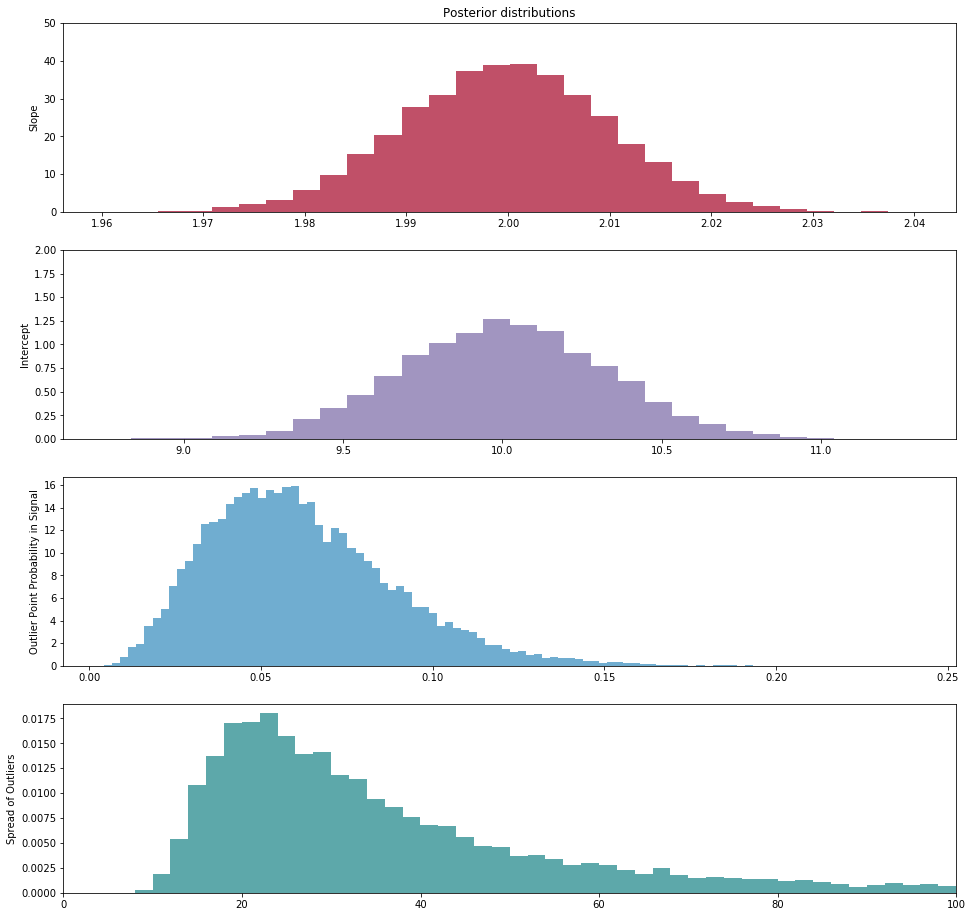

In [37]:
fix, ax = plt.subplots(figsize=(16,16))

ax = plt.subplot(411)
plt.hist(slope_and_intercept_trace[:,0], histtype='stepfilled', bins=30, alpha=.7,
                                        color="#A60628", normed=True);
plt.legend(loc="upper left");
plt.title("Posterior distributions");
plt.ylim([0, 50]);
plt.ylabel("Slope");

ax = plt.subplot(412);
plt.hist(slope_and_intercept_trace[:,1], histtype='stepfilled', bins=30, 
         alpha=.7, color="#7A68A6", normed=True);
plt.legend(loc="upper left");
plt.ylim([0, 2]);
plt.ylabel("Intercept");

plt.subplot(413);
plt.hist(outlier_points_trace, histtype='stepfilled', bins=100, alpha=.7,
         color="#348ABD",  normed=True);
plt.ylabel("Outlier Point Probability in Signal");

plt.subplot(414);
plt.hist(spread_outliers_trace, histtype='stepfilled', bins=100, alpha=.7,
         color="#188487",  normed=True);
plt.ylabel("Spread of Outliers");
plt.xlim([0, np.max(spread_outliers_trace)]);

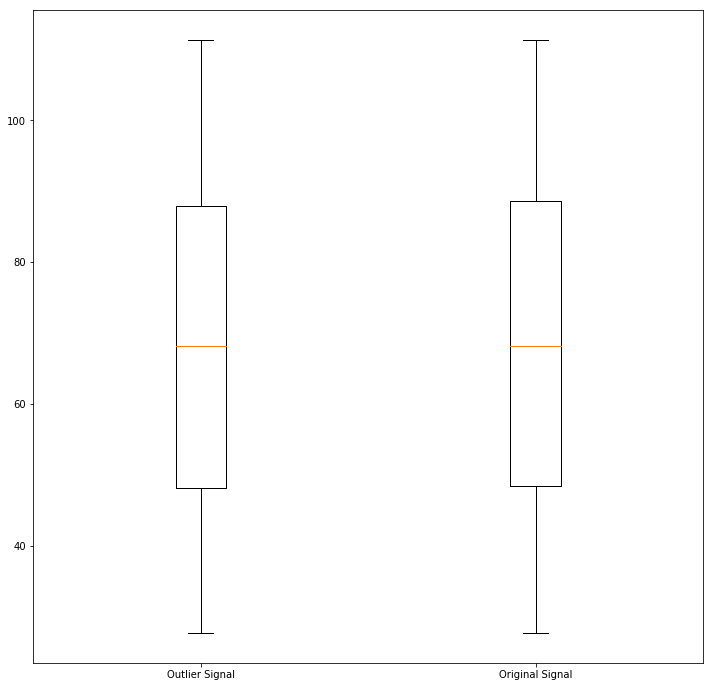

In [38]:
fig = plt.figure(figsize=(12, 12));
plt.boxplot([y_with_outlier, y]);
plt.xticks([1, 2], ['Outlier Signal', 'Original Signal']);

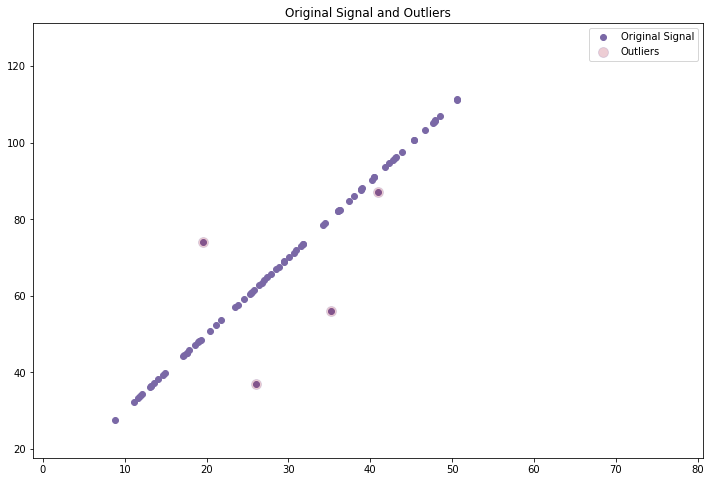

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y_with_outlier, c='#7A68A6', lw=1, label='Original Signal')
ax.scatter(outlier_x, outlier_y,  facecolors='#A60628', edgecolors='#7A68A6', label='Outliers', lw=1, s=100, alpha=0.2)

ax.set_xlim(np.min(x)-10, np.max(x) + 30);
ax.set_ylim(np.min(y_with_outlier)-10, np.max(y_with_outlier) + 20);
ax.set_title('Original Signal and Outliers');
plt.legend();